In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Nominal trajectory, measurements

In [46]:
class MonoCamera:
    def control(self, X, t):
        u_g = np.sin(0.2*t)
        return u_g

    def f(self, X, t, U='closedloop'):
        g, d = X
        # control
        if type(U) == str:
          if U == 'closedloop':
            u_g = self.control(X, t)
        else:
            u_g = np.interp(t, self.tsim, U)
        # dynamics
        g_dot = u_g
        d_dot = 0
        x_dot = [g_dot, d_dot]
        return x_dot

    def h(self, X, t):
        g, d = X
        y = g/d
        return np.atleast_2d(y)

    def simulate(self, x0, tsim, U='closedloop'):
        self.tsim = tsim
        result = odeint(self.f, x0, tsim, args=(U,))
        X = result.T
        Y = self.h(X, tsim)
        if type(U) == str:
          if U == 'closedloop':
            U = self.control(X, tsim)
        return X, Y, U

In [47]:
sys = MonoCamera()

x0 = np.array([0, 3])
tsim = np.arange(0, 100, 0.01)

X, Y, U = sys.simulate(x0, tsim)

Text(0, 0.5, 'Measurement values')

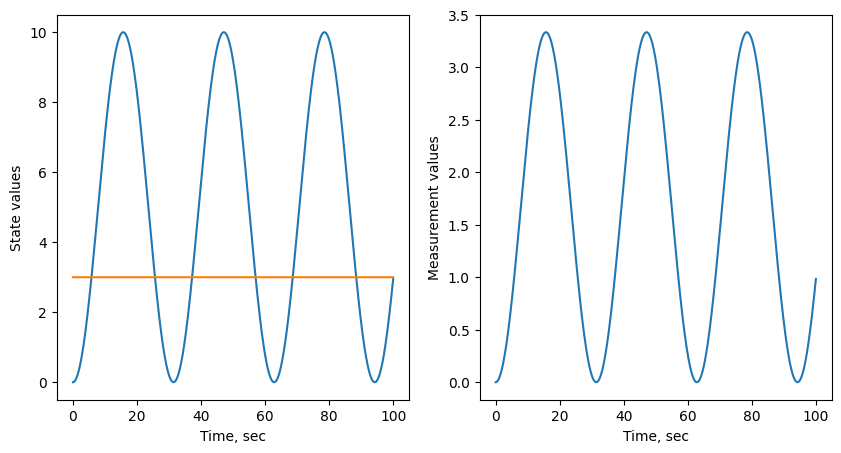

In [48]:
fig = plt.figure(figsize=(10,5))

# States
ax = fig.add_subplot(121)

ax.plot(tsim, X[0,:])
ax.plot(tsim, X[1,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('State values')

# Measurements
ax = fig.add_subplot(122)

ax.plot(tsim, Y[0,:])

ax.set_xlabel('Time, sec')
ax.set_ylabel('Measurement values')

In [49]:
X.shape

(2, 10000)

# Empirical Observability Matrix

In [52]:
def empirical_observability_matrix(system, x0, tsim, eps=1e-4):
    """ Empirically calculates the observability matrix O for a given system & input.

        Inputs
            system:             simulator object
            x0:                 initial state
            tsim:               simulation time
            usim:               simulation inputs
            eps:                amount to perturb initial state

        Outputs
            O:                  numerically calculated observability matrix
            X                   nominal trajectory simulation data
            deltay:             the difference in perturbed measurements at each time step
                                (basically O stored in a 3D array)
    """

    # Simulate once for nominal trajectory
    X, Y, U = system.simulate(x0, tsim, U='closedloop')
    n_state = X.shape[0]  # number of states
    n_output = Y.shape[0]  # number of outputs

    # Calculate O
    w = len(tsim)  # of points in time window
    delta = eps * np.eye(n_state)  # perturbation amount for each state
    deltay = np.zeros((n_output, n_state, w))  # preallocate deltay
    for k in range(n_state):  # each state
        # Perturb initial condition in both directions
        x0plus = x0 + delta[:, k]
        x0minus = x0 - delta[:, k]

        # Simulate measurements from perturbed initial conditions
        _, yplus, _ = system.simulate(x0plus, tsim, U=U)
        _, yminus, _ = system.simulate(x0minus, tsim, U=U)

        # Calculate the numerical Jacobian & normalize by 2x the perturbation amount
        deltay[:, k, :] = np.array(yplus - yminus) / (2 * eps)

    # Construct O by stacking the 3rd dimension of deltay along the 1st dimension, O is a (p*m x n) matrix
    O = []  # list to store datat at each time point fo O
    for j in range(w):
        O.append(deltay[:, :, j])

    O = np.vstack(O)

    return O, X, deltay

# Sinusoidal trajectory

In [53]:
# Define system with sinusoidal trajectory
sys = MonoCamera()
def control(X, t):
    u_g = np.sin(0.2*t)
    return u_g
sys.control = control

# Establish initial condition and simulation times
x0 = np.array([0, 3])
tsim = np.arange(0, 100, 0.01)

# Get the empirical observability matrix
O, X, deltay = empirical_observability_matrix(sys, x0, tsim, eps=1e-4)

# Analyze O
W = O.T@O
eig = np.linalg.eigvals(W)
CN = np.max(eig) / np.min(eig)
print('Condition Number = ', CN)
print('')
print('Observability Gramian:')
print(W)

Condition Number =  15.290413659305012

Observability Gramian:
[[ 1104.0421238  -1761.03391222]
 [-1761.03391222  4376.54530794]]


# Constant velocity trajectory

In [55]:
# Define system with sinusoidal trajectory
sys = MonoCamera()
def control(X, t):
    u_g = np.zeros_like(t)
    return u_g
sys.control = control

# Establish initial condition and simulation times
x0 = np.array([0, 3])
tsim = np.arange(0, 100, 0.01)

# Get the empirical observability matrix
O, X, deltay = empirical_observability_matrix(sys, x0, tsim, eps=1e-4)

# Analyze O
W = O.T@O
eig = np.linalg.eigvals(W)
CN = np.max(eig) / np.min(eig)
print('Condition Number = ', CN)
print('')
print('Observability Gramian:')
print(W)

Condition Number =  inf

Observability Gramian:
[[1111.11111111    0.        ]
 [   0.            0.        ]]


<ipython-input-55-6e5e338535ae>:18: RuntimeWarning: divide by zero encountered in scalar divide
  CN = np.max(eig) / np.min(eig)
